In [1]:
import glob
import calendar

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
obs_files = sorted(glob.glob("/g/data/zv2/agcd/v2-0-1/precip/total/r005/01month/agcd_v2-0-1_precip_total_r005_monthly_*.nc"))
hist_file = "/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Amon/pr/gn/v20191115/pr_Amon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc"
ssp_file = "/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/Amon/pr/gn/v20191115/pr_Amon_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_201501-210012.nc"

baseline_start = "1985-01-01"
baseline_end = "2014-12-31"
future_start = "2070-01-01"
future_end = "2099-12-31"

city = 'Geraldton'

In [3]:
city_lat_lon = {
    'Hobart': (-42.9, 147.3),
    'Melbourne': (-37.8, 145.0),
    'Thredbo': (-36.5, 148.3),
    'Sydney': (-33.9, 151.2),
    'Brisbane': (-27.5, 153.0),
    'Cairns': (-16.9, 145.8),
    'Darwin': (-12.5, 130.8),
    'Alice Springs': (-23.7, 133.9),
    'Port Hedland': (-20.3, 118.6),
    'Geraldton': (-28.8, 114.6),
    'Perth': (-32.0, 115.9),
    'Adelaide': (-34.9, 138.6),
}

In [4]:
lat, lon = city_lat_lon[city]

In [5]:
ds_obs = xr.open_mfdataset(obs_files)
ds_obs = ds_obs.sel(lat=lat, lon=lon, method='nearest')
ds_obs = ds_obs.sel(time=slice(baseline_start, baseline_end))
ds_obs = ds_obs.rename({'precip': 'pr'})
ds_obs = ds_obs.compute()

In [6]:
ds_hist = xr.open_dataset(hist_file)
ds_hist = ds_hist.sel(lat=lat, lon=lon, method='nearest')
ds_hist = ds_hist.sel(time=slice(baseline_start, baseline_end))
ds_hist['pr'] = (ds_hist['pr'] * 86400) * ds_hist['time'].dt.days_in_month
ds_hist['pr'].attrs['units'] = 'mm'
ds_hist = ds_hist.compute()

In [7]:
ds_future = xr.open_dataset(ssp_file)
ds_future = ds_future.sel(lat=lat, lon=lon, method='nearest')
ds_future = ds_future.sel(time=slice(future_start, future_end))
ds_future['pr'] = (ds_future['pr'] * 86400) * ds_future['time'].dt.days_in_month
ds_future['pr'].attrs['units'] = 'mm'
ds_future = ds_future.compute()

In [8]:
obs_monthly_mean = ds_obs['pr'].groupby('time.month').mean('time')
hist_monthly_mean = ds_hist['pr'].groupby('time.month').mean('time')
future_monthly_mean = ds_future['pr'].groupby('time.month').mean('time')

In [9]:
obs_annual = ds_obs['pr'].resample(time='Y').sum()
hist_annual = ds_hist['pr'].resample(time='Y').sum()
future_annual = ds_future['pr'].resample(time='Y').sum()

In [10]:
obs_annual_mean = obs_annual.mean('time')
hist_annual_mean = hist_annual.mean('time')
future_annual_mean = future_annual.mean('time')

In [11]:
obs_monthly_annual_pct = (obs_monthly_mean.values / obs_annual_mean.values) * 100 
hist_monthly_annual_pct = (hist_monthly_mean.values / hist_annual_mean.values) * 100

## Model change in rainfall

In [12]:
future_annual_mean.values

array(193.16421077)

In [13]:
hist_annual_mean.values

array(323.81530849)

In [14]:
model_rainfall_change = ((future_annual_mean.values - hist_annual_mean.values) / hist_annual_mean.values) * 100
print(f'Modelled change in annual mean rainfall: {model_rainfall_change:.1f}%')

Modelled change in annual mean rainfall: -40.3%


In [15]:
model_rainfall_change_month_pct = ((future_monthly_mean.values - hist_monthly_mean.values) / hist_annual_mean.values) * 100

In [16]:
model_rainfall_change_month_pct.sum()

-40.34741233515578

## Apply delta change method

In [17]:
monthly_adjustment_factors = future_monthly_mean / hist_monthly_mean

In [18]:
da_dc = ds_obs['pr'].groupby('time.month') * monthly_adjustment_factors
da_dc = da_dc.compute()

## Delta change in rainfall

In [19]:
dc_monthly_mean = da_dc.groupby('time.month').mean('time')

In [20]:
dc_annual = da_dc.resample(time='Y').sum()

In [21]:
dc_annual_mean = dc_annual.mean('time')

In [22]:
dc_annual_mean.values

array(279.5149511)

In [23]:
obs_annual_mean.values

array(418.57907, dtype=float32)

In [24]:
dc_rainfall_change = ((dc_annual_mean.values - obs_annual_mean.values) / obs_annual_mean.values) * 100
print(f'Change in annual mean rainfall (delta change method): {dc_rainfall_change:.1f}%')

Change in annual mean rainfall (delta change method): -33.2%


In [25]:
dc_rainfall_change_month_pct = ((dc_monthly_mean.values - obs_monthly_mean.values) / obs_annual_mean.values) * 100

In [26]:
dc_rainfall_change_month_pct

array([ -0.65204874,  -1.26427179,  -2.64542251,  -2.85192781,
        -7.59464158,   1.78338067, -10.7337762 ,  -4.19118645,
        -1.9557637 ,  -2.22917159,  -0.75585957,  -0.13221436])

In [27]:
dc_rainfall_change_month_pct.sum()

-33.222903628007

## Summary plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


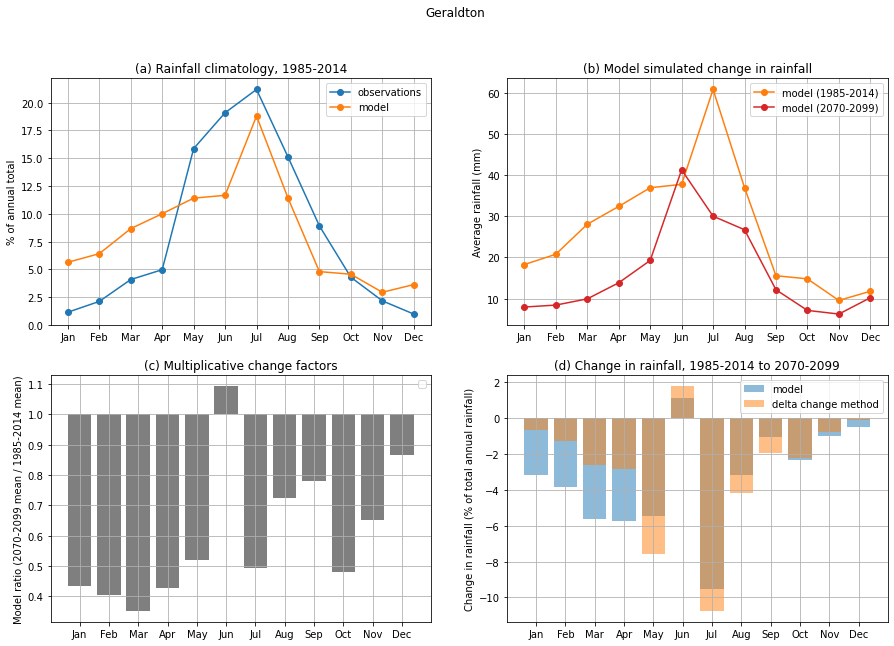

In [28]:
fig = plt.figure(figsize=[15, 10])
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

xticks = np.arange(1, 13)
xtick_labels = [calendar.month_abbr[i] for i in xticks]

ax1.plot(xticks, obs_monthly_annual_pct, label='observations', marker='o')
ax1.plot(xticks, hist_monthly_annual_pct, label='model', marker='o')
ax1.set_title('(a) Rainfall climatology, 1985-2014')
ax1.legend()
ax1.set_ylabel('% of annual total')
ax1.set_xticks(xticks, xtick_labels)
ax1.grid()

ax2.plot(xticks, hist_monthly_mean, label='model (1985-2014)', marker='o', color='tab:orange')
ax2.plot(xticks, future_monthly_mean, label='model (2070-2099)', marker='o', color='tab:red')
ax2.set_title('(b) Model simulated change in rainfall')
ax2.legend()
ax2.set_ylabel('Average rainfall (mm)')
ax2.set_xticks(xticks, xtick_labels)
ax2.grid()

ax3.bar(xticks, monthly_adjustment_factors - 1.0, bottom=1.0, color='tab:grey')
ax3.set_title('(c) Multiplicative change factors')
ax3.legend()
ax3.set_ylabel('Model ratio (2070-2099 mean / 1985-2014 mean)')
ax3.set_xticks(xticks, xtick_labels)
ax3.grid()

ax4.bar(xticks, model_rainfall_change_month_pct, alpha=0.5, label='model')
ax4.bar(xticks, dc_rainfall_change_month_pct, alpha=0.5, label='delta change method')
ax4.set_title('(d) Change in rainfall, 1985-2014 to 2070-2099')
ax4.legend()
ax4.set_ylabel('Change in rainfall (% of total annual rainfall)')
ax4.set_xticks(xticks, xtick_labels)
ax4.grid()

plt.suptitle(city)
plt.savefig(f'precip_delta_change_example_{city}.png', dpi=300)